In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nips-papers/paper_authors.csv
/kaggle/input/nips-papers/papers.csv
/kaggle/input/nips-papers/authors.csv
/kaggle/input/nips-papers/database.sqlite


# Topic Modeling in Python - LDA Analysis

* [Reference](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)

More references:

* [1] Topic model — Wikipedia. https://en.wikipedia.org/wiki/Topic_model
* [2] Distributed Strategies for Topic Modeling. https://www.ideals.illinois.edu/bitstream/handle/2142/46405/ParallelTopicModels.pdf?sequence=2&isAllowed=y
* [3] Topic Mapping — Software — Resources — Amaral Lab. https://amaral.northwestern.edu/resources/software/topic-mapping
* [4] A Survey of Topic Modeling in Text Mining. https://thesai.org/Downloads/Volume6No1/Paper_21-A_Survey_of_Topic_Modeling_in_Text_Mining.pdf

In [2]:
papers = pd.read_csv('/kaggle/input/nips-papers/papers.csv')
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [3]:
# Clean unnecessary columns and limit the size of sample
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1).sample(100)

## Remove punctuation and lowercasing

In [4]:
import re

In [5]:
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('', '', x))
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())
papers['paper_text_processed'].head()

4057    context-sensitive decision forests\nfor object...
219     783\n\nusing neural networks to improve\ncochl...
874     learning continuous distributions:\nsimulation...
6375    reliable decision support using\ncounterfactua...
704     generalized model selection for unsupervised\n...
Name: paper_text_processed, dtype: object

## Exploratory analysis

To verify whether the preprocessing, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

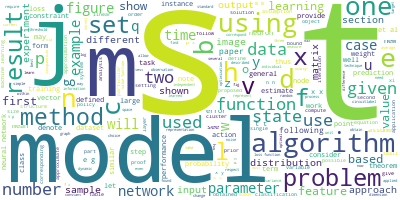

In [8]:
from wordcloud import WordCloud

long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color='white', max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

## Prepare data for LDA Analysis

In [10]:
import gensim
from gensim.utils import simple_preprocess

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def send_to_words(sentences):
    for sentence in sentences:
        # deacc=remove punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
        
data = papers.paper_text_processed.values.tolist()
data_words = list(send_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

In [19]:
import gensim.corpora as corpora

# Generate a map of id2words (a Dictionary)
id2word = corpora.Dictionary(data_words)

# Creates corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

## LDa model training

In [24]:
from pprint import pprint

# Define number of topics
num_topics = 10

model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# Print the keyword in the 10 topics
pprint(model.print_topics())

doc_lda = model[corpus]

## Analyze LDA model results

In [28]:
# import pyLDAvis.gensim
import pickle
import pyLDAvis

pyLDAvis.enable_notebook()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
